<a href="https://colab.research.google.com/github/EHDEV/sp_analytics/blob/master/scrape_tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Scraping Tweets

### Tweet Scraper Notebook

#### Scrape, transform (dedup, clean, etc) and save

- Define a list of accounts to pull tweets from (divided into a batch of 25 accounts)
- For each batch of accounts, scrape tweets into a dataframe
    + Alternatively add a date parameter to the query (`since: date`)
- Merge the dataframes
- Clean, dedup and transform
- Save dataframes into CSV's based on date collected
- Add a readme for each csv with the query used to collect tweets

#### Analyze

- Basic aggregation of tweets
- Group tweets by account
- Timeline of tweets by individual accounts
- Group and aggregate tweets from accounts by keywords
- Group and aggregate tweets for all by keywords

...

In [1]:
!pip install snscrape

In [2]:
import snscrape.modules.twitter as sntwitter

In [53]:
import pandas as pd
import re
from datetime import date

In [86]:
todays_date = date.today().strftime('%Y-%m-%d')

accounts = [
    'afp', 'rcoreyb', 'nytimes', 'reuters', 'reutersafrica', 'cnni', 'cnn', 'cnnafrica', 'theeconomist', 'bbc', 
    'bbcafrica', 'ap', 'guardian', 'telegraph', 'globeandmail', 'washingtonpost', 'voanews', 'dwnews', 
    'foreignpolicy','foreignaffairs', 'bbgafrica', 'ajenglish', 'business', 'voaafrica'
]

# accounts = ['aljazeera', 'ajnews', 'aljazeera_world', 'ajenglish']
# 'pbs', 'npr', 'skynews',
# other_un_accounts = ['un_pga', 'gaviseth', 'morenobid', 'pespinosac', 'lagarde', 'jimyongkim', 'eriksolheim', 'almagro_oea2015']
from_accounts_text = '( ' + ' '.join([f'from:{x} OR' for x in accounts[:-1]]) + ' from:' + accounts[-1] + ' )'
from_accounts_text


'( from:afp OR from:rcoreyb OR from:nytimes OR from:reuters OR from:reutersafrica OR from:cnni OR from:cnn OR from:cnnafrica OR from:theeconomist OR from:bbc OR from:bbcafrica OR from:ap OR from:guardian OR from:telegraph OR from:globeandmail OR from:washingtonpost OR from:voanews OR from:dwnews OR from:foreignpolicy OR from:foreignaffairs OR from:bbgafrica OR from:ajenglish OR from:business OR from:voaafrica )'

In [115]:
search_terms = [
    'ethiopia', 'tigray'
]

search_terms_text = '( ' + ' '.join([f'{x} OR' for x in search_terms[:-1]]) + ' ' + search_terms[-1] + ' )'


advanced_search_citeria = '-filter:replies lang:en since:2019-11-01'

search_criteria_full = ' '.join([from_accounts_text, search_terms_text, advanced_search_citeria])


In [116]:
search_criteria_full

'( from:afp OR from:rcoreyb OR from:nytimes OR from:reuters OR from:reutersafrica OR from:cnni OR from:cnn OR from:cnnafrica OR from:theeconomist OR from:bbc OR from:bbcafrica OR from:ap OR from:guardian OR from:telegraph OR from:globeandmail OR from:washingtonpost OR from:voanews OR from:dwnews OR from:foreignpolicy OR from:foreignaffairs OR from:bbgafrica OR from:ajenglish OR from:business OR from:voaafrica ) ( ethiopia OR tigray ) -filter:replies lang:en since:2019-11-01'

In [117]:

# Creating list to append tweet data 
tweets_list1 = []


# Using TwitterSearchScraper to scrape data and append tweets to list
for i,tweet in enumerate(sntwitter.TwitterSearchScraper(search_criteria_full).get_items()): #declare a username 
    # import pdb; pdb.set_trace()
    if i>1000000: #number of tweets you want to scrape
        break
    tweets_list1.append([tweet.date, tweet.id, tweet.content, tweet.username, tweet.url]) #declare the attributes to be returned
    
# Creating a dataframe from the tweets list above 
df_tweets = pd.DataFrame(tweets_list1, columns=['datetime', 'tweet_id', 'tweet_text', 'username', 'tweet_url'])

In [118]:
df_tweets.shape

(6043, 5)

In [119]:
pd.set_option('display.max_colwidth', -1)

df_tweets.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


,datetime,tweet_id,tweet_text,username,tweet_url
0,2021-11-19 02:21:33+00:00,1461519985843474433,"Crises in Sudan, Ethiopia Flare as Blinken Visits Africa https://t.co/VT49xxP8E8",VOAAfrica,https://twitter.com/VOAAfrica/status/1461519985843474433
1,2021-11-19 01:29:00+00:00,1461506762138210304,A manhunt in Ethiopia's capital is underway for anyone suspected of being linked to Tigrayan rebels — and some residents are joining in. https://t.co/xJlkUyt5xr,dwnews,https://twitter.com/dwnews/status/1461506762138210304
2,2021-11-18 21:35:17+00:00,1461447944935284738,U.S. envoy meets Ethiopia deputy PM in bid to revive truce efforts https://t.co/SVtvEAC5qU https://t.co/RT4RNtc3Sk,Reuters,https://twitter.com/Reuters/status/1461447944935284738
3,2021-11-18 18:05:15+00:00,1461395090665086976,U.S. envoy meets Ethiopia deputy PM in bid to revive truce efforts https://t.co/jaLx4HMIbf https://t.co/gxoVzLms9F,Reuters,https://twitter.com/Reuters/status/1461395090665086976
4,2021-11-18 16:29:33+00:00,1461371006988206089,"Coming up on #AfricaNewsTonight: U.S. top diplomat Anthony Blinken continues Africa tour, calls for a ceasefire in Ethiopia and U.S. pushes to restore Sudan’s democratic transition. \n\nTune in @ 16:00 &amp; 18:00 UTC: https://t.co/RrVCAPu2cW https://t.co/v3J3V4nRI8",VOAAfrica,https://twitter.com/VOAAfrica/status/1461371006988206089


In [120]:
df_tweets.columns = ['datetime', 'tweet_id', 'tweet_text', 'username', 'tweet_url']

In [124]:
df_tweets['date'] = df_tweets['datetime'].dt.date

## Clean, Dedup, Transform

- Extract any link to a separate column (`external_link`) and remove from `tweet_text`
- Drop duplicates by `tweet_id`
- Remove tagged accounts from `tweet_text` [optional]

In [142]:

def extract_url(text):
    
    regex = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
    match = re.search(regex, text)
    if match:
        return match.group()    
    return ''

def remove_url(text):
    regex = r"http\S+"
    return re.sub(regex, "", text)

usernames_to_main_account_map = {
    'afpafrica': 'AFP',
    'bbgafrica': 'Bloomberg',
    'business': 'Bloomberg',
    'cnnafrica': 'CNN',
    'cnni': 'CNN',
    'cnn': 'CNN',
    'reutersafrica': 'Reuters',
    'reuters': 'Reuters',
    'voaafrica': 'VOA',
    'voanews': 'VOA',
    'bbcafrica': 'BBC',
    'afp': 'AFP',
    'globeandmail': 'GlobeAndMail',
    'nytimes': 'NYTimes',
    'foreignaffairs': 'ForeignAffairs',
    'foreignpolicy': 'ForeignPolicy',
    'guardian': 'TheGuardian',
    'washingtonpost': 'WashingtonPost',
    'dwnews': 'DeutscheWelle',
    'ajenglish': 'Aljazeera',
    'telegraph': 'Telegraph',
    'ap': 'AP',
    'theeconomist': 'TheEconomist'
}

def extract_media_org(name):
    return usernames_to_main_account_map.get(name, name)


df_tweets['external_link'] = df_tweets['tweet_text'].apply(extract_url)

df_tweets['tweet_text'] = df_tweets['tweet_text'].apply(remove_url)

# replacing rcoreyb with afpafrica since afpafrica has recently been deactivated
df_tweets['username'] = df_tweets['username'].str.replace('rcoreyb', 'afpafrica')

df_tweets['media_organization'] = df_tweets.username.str.lower().apply(extract_media_org)
df_tweets.drop_duplicates(subset=['tweet_id'], inplace=True)
df_tweets.shape


(6043, 8)

In [143]:
df_tweets.head(3)

,datetime,tweet_id,tweet_text,username,tweet_url,date,external_link,media_organization
0,2021-11-19 02:21:33+00:00,1461519985843474433,"Crises in Sudan, Ethiopia Flare as Blinken Visits Africa",VOAAfrica,https://twitter.com/VOAAfrica/status/1461519985843474433,2021-11-19,,VOA
1,2021-11-19 01:29:00+00:00,1461506762138210304,A manhunt in Ethiopia's capital is underway for anyone suspected of being linked to Tigrayan rebels — and some residents are joining in.,dwnews,https://twitter.com/dwnews/status/1461506762138210304,2021-11-19,,DeutscheWelle
2,2021-11-18 21:35:17+00:00,1461447944935284738,U.S. envoy meets Ethiopia deputy PM in bid to revive truce efforts,Reuters,https://twitter.com/Reuters/status/1461447944935284738,2021-11-18,,Reuters


In [176]:
csv_name = f'tweets_from_major_us_eu_uk_canada_news_orgs_extracted_{todays_date}'
full_path = f'./drive/MyDrive/tweet_data/{csv_name}'

In [175]:
df_tweets.to_csv(full_path, index=False)

## Load CSV Data

In [7]:
import pandas as pd
from datetime import date

In [8]:
todays_date = date.today().strftime('%Y-%m-%d')

csv_name = f'tweets_from_major_us_eu_uk_canada_news_orgs_extracted_{todays_date}'
full_path = f'./drive/MyDrive/tweet_data/{csv_name}'

In [9]:
df_tweets = pd.read_csv(full_path)

In [10]:
# tweets_df1.head(10)[['URL', 'Text']].to_dict(orient='records')\\
df_tweets.username.value_counts()

Reuters           981
ReutersAfrica     894
afpafrica         497
BBGAfrica         442
AJEnglish         384
TheEconomist      325
business          305
VOAAfrica         290
BBCAfrica         282
AFP               262
ForeignPolicy     213
VOANews           186
dwnews            156
AP                139
globeandmail      133
CNNAfrica         114
cnni              101
guardian           92
ForeignAffairs     88
CNN                57
nytimes            54
washingtonpost     32
Telegraph          16
Name: username, dtype: int64

## Analysis

In [11]:
from matplotlib.pyplot import figure
import seaborn as sbn
import plotly.express as px


#### Volume of tweets by Media Organization (since 2019-11-01)

In [156]:
31*9

279

In [31]:
df_agg = df_tweets[['media_organization', 'tweet_url']].groupby('media_organization')\
    .count() \
    .sort_values(['tweet_url'], ascending=False).reset_index()

fig = px.bar(df_agg, x='media_organization', y='tweet_url',
             labels={'tweet_url':'Volume of Tweets (Articles)'}, height=600)
fig.show()

In [80]:
df_agg = df_tweets[['date', 'tweet_url']].groupby('date')\
    .count() \
    .sort_values(['tweet_url'], ascending=False).reset_index()

fig = px.area(df_agg, 
                x='date', y='tweet_url',
                labels={'tweet_url':'Volume of Articles (Tweeted)', 'date':'Publish Date'}, 
                color_discrete_sequence=['green'],
                height=600)

fig.update_layout(title_text='Western Media Coverage of Ethiopia for 2019, 2020 and 2021 (Before and After the Conflict in the North)', title_x=0.5)

fig.add_vrect(
    x0='2019-11-03', 
    x1='2020-11-03', 
    fillcolor='blue', 
    opacity=0.15, 
    line_width=0,
    annotation=dict(font_size=20, font_family="Tahoma"),
    annotation_text="Before the Conflict", 
    annotation_position="top left"
)
fig.add_vrect(
    x0='2020-11-03', 
    x1='2021-11-18', 
    fillcolor='red', 
    opacity=0.15, 
    line_width=0,
    annotation=dict(font_size=20, font_family="Tahoma"),
    annotation_text="After the Conflict", 
    annotation_position="top left"
)
fig.show()

In [33]:
df_agg.head()

,media_organization,tweet_url
0,Reuters,1875
1,AFP,759
2,Bloomberg,747
3,VOA,476
4,Aljazeera,384


In [83]:
df_agg = df_tweets[df_tweets.datetime > '2020-10-15'][['date', 'tweet_url']].groupby('date')\
    .count() \
    .sort_values(['tweet_url'], ascending=False).reset_index()


fig = px.area(df_agg, 
                x='date', y='tweet_url',
                labels={'tweet_url':'Volume of Articles (Tweeted)', 'date':'Publish Date'}, 
                color_discrete_sequence=['green'],
                height=600
            )

fig.update_layout(title_text='Western Media Coverage of Ethiopia after the Conflict in the North Began (2020 and 2021)', title_x=0.5)


fig.add_vrect(
    x0='2020-11-05', 
    x1='2020-11-28', 
    fillcolor='orange', 
    opacity=0.25, 
    line_width=0,
    annotation=dict(font_size=12, font_color='darkred', font_family="Tahoma"),
    annotation_text="TPLF Attacks, ENDF Responds", 
    # annotation_position="top right"
)

fig.add_vrect(
    x0='2021-06-28', 
    x1='2021-07-02', 
    fillcolor='yellow', 
    opacity=0.50, 
    line_width=0,
    annotation=dict(font_size=12, font_color='brown', font_family="Tahoma"),
    annotation_text="Unilateral Ceasefire", 
    # annotation_position="top right"
)
fig.add_vrect(
    x0='2021-11-02', 
    x1='2021-11-06', 
    fillcolor='red', 
    opacity=0.25, 
    line_width=0,
    annotation=dict(font_size=12, font_color='darkred', font_family="Tahoma"),
    annotation_text="TPLF is Marching to Addis Hysteria ", 
    # annotation_position="top right"
)
fig.show()

In [57]:
df_agg = df_tweets[df_tweets.datetime > '2020-10-15'][['date', 'tweet_url']].groupby('date')\
    .count() \
    .sort_values(['tweet_url'], ascending=False).reset_index()


fig = px.area(df_agg, 
                x='date', y='tweet_url',
                labels={'tweet_url':'Volume of Articles (Tweeted)', 'date':'Publish Date'}, 
                color_discrete_sequence=['green'],
                height=600
            )

fig.update_layout(title_text='Western Media Coverage of Ethiopia after the Conflict in the North Began (2020 and 2021)', title_x=0.5)


fig.add_vrect(
    x0='2020-11-05', 
    x1='2020-11-28', 
    fillcolor='orange', 
    opacity=0.25, 
    line_width=0,
    annotation=dict(font_size=12, font_color='darkred', font_family="Tahoma"),
    annotation_text="TPLF Attacks, ENDF Responds", 
    # annotation_position="top right"
)

fig.add_vrect(
    x0='2021-06-28', 
    x1='2021-07-02', 
    fillcolor='yellow', 
    opacity=0.50, 
    line_width=0,
    annotation=dict(font_size=12, font_color='brown', font_family="Tahoma"),
    annotation_text="Unilateral Ceasefire", 
    # annotation_position="top right"
)
fig.add_vrect(
    x0='2021-11-02', 
    x1='2021-11-06', 
    fillcolor='red', 
    opacity=0.25, 
    line_width=0,
    annotation=dict(font_size=12, font_color='darkred', font_family="Tahoma"),
    annotation_text="TPLF is Marching to Addis Hysteria ", 
    # annotation_position="top right"
)
fig.show()

,datetime,tweet_id,tweet_text,username,tweet_url,date,external_link,media_organization
4231,2020-11-19 23:13:47+00:00,1329563550235451394,Why is Ethiopia facing civil war? – video expl...,guardian,https://twitter.com/guardian/status/1329563550...,2020-11-19,NaN,TheGuardian
4232,2020-11-19 19:41:03+00:00,1329510016538316810,A university official says the latest airstrik...,AP,https://twitter.com/AP/status/1329510016538316810,2020-11-19,NaN,AP
4233,2020-11-19 19:38:03+00:00,1329509261647507457,"Ethiopia moves on Tigray capital, castigates W...",ReutersAfrica,https://twitter.com/ReutersAfrica/status/13295...,2020-11-19,NaN,Reuters
4234,2020-11-19 19:06:10+00:00,1329501239013412866,The conflict in #Ethiopia between the federal ...,VOAAfrica,https://twitter.com/VOAAfrica/status/132950123...,2020-11-19,NaN,VOA
4235,2020-11-19 19:03:06+00:00,1329500465386631171,Every two years the Mo Ibrahim Foundation rele...,VOAAfrica,https://twitter.com/VOAAfrica/status/132950046...,2020-11-19,NaN,VOA
4236,2020-11-19 18:59:57+00:00,1329499671484633098,#BREAKING WHO chief denies 'taking sides' in E...,AFP,https://twitter.com/AFP/status/132949967148463...,2020-11-19,NaN,AFP
4237,2020-11-19 17:15:00+00:00,1329473260715577345,Ethiopia's military has accused the head of th...,Reuters,https://twitter.com/Reuters/status/13294732607...,2020-11-19,NaN,Reuters
4238,2020-11-19 16:40:00+00:00,1329464452383731713,Thousands of cranes made a pit stop in Israel....,Reuters,https://twitter.com/Reuters/status/13294644523...,2020-11-19,NaN,Reuters
4239,2020-11-19 16:00:00+00:00,1329454386033135618,From spearheading the struggle against dictato...,AFP,https://twitter.com/AFP/status/132945438603313...,2020-11-19,NaN,AFP
4240,2020-11-19 15:45:04+00:00,1329450630625325057,Ethiopia’s army accuses WHO head of aiding the...,business,https://twitter.com/business/status/1329450630...,2020-11-19,NaN,Bloomberg


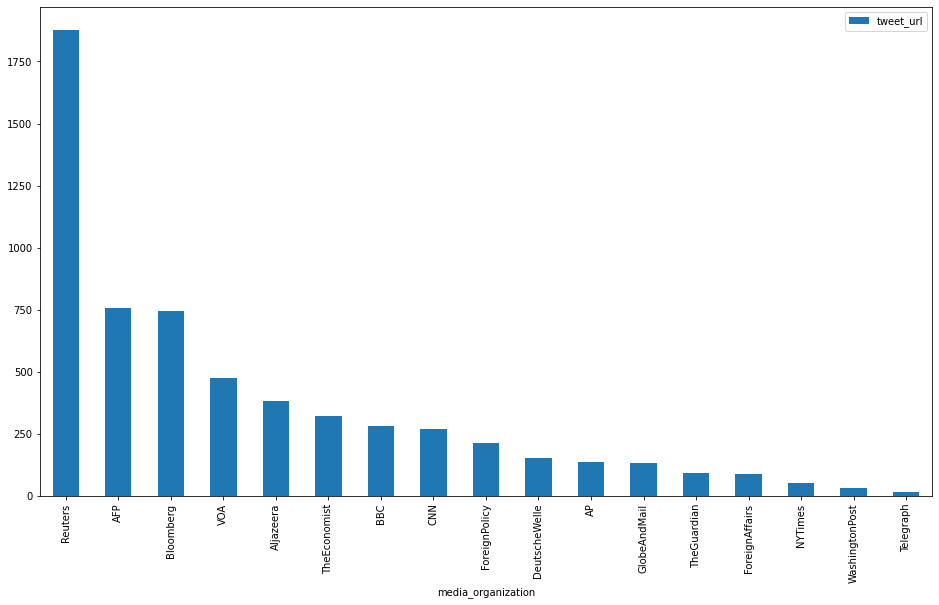

In [158]:

df_tweets[['media_organization', 'tweet_url']].groupby('media_organization')\
    .count() \
    .sort_values(['tweet_url'], ascending=False)\
    .plot(kind='bar', figsize=(16,9))

In [ ]:
df_tweets[['date', 'tweet_url']].groupby('media_organization')\
    .count() \
    .sort_values(['tweet_url'], ascending=False)\
    .plot(kind='bar', figsize=(16,9))

In [ ]:
from matplotlib.pyplot import figure
from matplotlib import pyplot as plt
import matplotlib.dates as mdates


figure(figsize=(12, 8), dpi=80)


In [ ]:

agg = tweets_df1[['Datetime', 'URL']].groupby('Datetime')\
    .count() \
    .sort_values(['URL'], ascending=False)

agg['moving_average'] = agg.rolling(window=90).max()

fig, ax = plt.subplots(figsize=(20,7))
ax.set_yscale('linear')
ax.xaxis.set_major_locator(mdates.)

agg.URL.plot(kind='area', ax=ax)
# agg.moving_average.plot(kind='line', ax=ax)

plt.show()